In [182]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from src.data_processing.resultMetaUtils import frameFromResultMeta

In [183]:
# Create the datatframe from the results meta
df = frameFromResultMeta()
print(df.columns)
cols = ['meta.ticker', 'meta.numEpoch', 'meta.lookForwardHorizon', 'meta.rowLim', 'accuracy', 'meta.representation', 'meta.model', 'run_id']
df = df[cols]
# display(df)

Index(['run_id', 'accuracy', 'meta.model', 'meta.numEpoch', 'meta.ticker',
       'meta.steps', 'meta.trainTestSplit', 'meta.maxFiles', 'meta.threshold',
       'meta.rowLim', 'meta.lookForwardHorizon', 'meta.representation',
       'meta.batchSize', 'meta.scaling', 'meta.modelKwargs.shape',
       'meta.startDate', 'meta.trainDays'],
      dtype='object')


In [184]:
orderbook = df

# Conditions for orderbooks training
conditions = {
    'meta.rowLim': 1000000,
    'meta.numEpoch': 5,
    'meta.representation': 'orderbooks',
    'meta.model': 'deepLOB_TF'
}

for condition, value in conditions.items():
    orderbook = orderbook[orderbook[condition] == value]

tickers = orderbook['meta.ticker'].unique()

orderbooks = []
for ticker in tickers:
    orderbooks.append(
        orderbook.loc[orderbook['meta.ticker'] == ticker].sort_values('meta.lookForwardHorizon')
    )

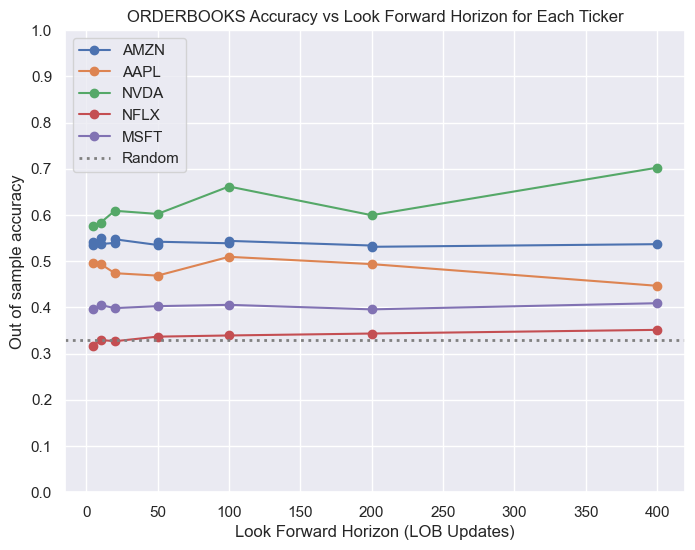

In [185]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
for d in orderbooks:
    d_sorted = d.sort_values('meta.lookForwardHorizon')
    ax.plot(
        d_sorted['meta.lookForwardHorizon'],
        d_sorted['accuracy'],
        marker='o',
        label=d_sorted['meta.ticker'].iloc[0]
    )
ax.set_xlabel('Look Forward Horizon (LOB Updates)')
ax.set_ylabel('Out of sample accuracy')
ax.set_ylim(0,1)
ax.set_title('ORDERBOOKS Accuracy vs Look Forward Horizon for Each Ticker')
ax.set_yticks([round(y, 1) for y in list(np.arange(0.0, 1.01, 0.1))])
ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
ax.legend()
plt.show()

In [186]:
orderflow = df

# Conditions for orderbooks training
conditions = {
    'meta.rowLim': 1000000,
    'meta.numEpoch': 5,
    'meta.representation': 'orderflows',
}

for condition, value in conditions.items():
    orderflow = orderflow[orderflow[condition] == value]

tickers = orderflow['meta.ticker'].unique()

orderflows = []
for ticker in tickers:
    orderflows.append(
        orderflow.loc[orderflow['meta.ticker'] == ticker].sort_values('meta.lookForwardHorizon')
    )
    
# display(orderflow)

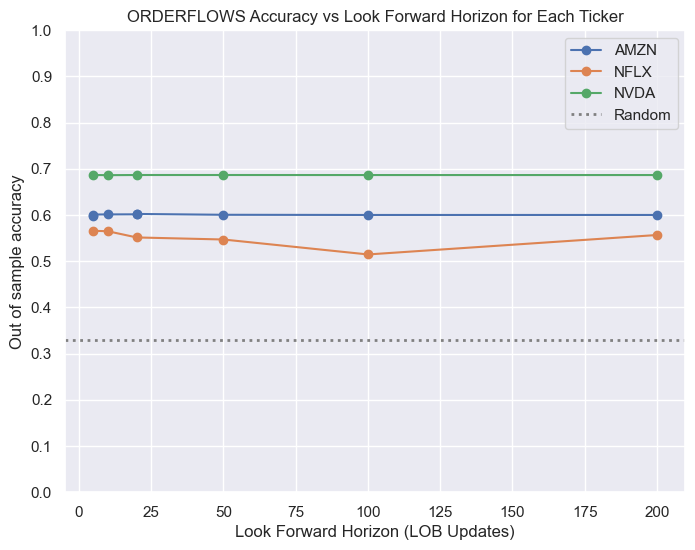

In [187]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
for d in orderflows:
    ax.plot(
        d['meta.lookForwardHorizon'],
        d['accuracy'],
        marker='o',
        label=d['meta.ticker'].iloc[0]
    )
ax.set_xlabel('Look Forward Horizon (LOB Updates)')
ax.set_ylabel('Out of sample accuracy')
ax.set_ylim(0,1)
ax.set_title('ORDERFLOWS Accuracy vs Look Forward Horizon for Each Ticker')
ax.set_yticks([round(y, 1) for y in list(np.arange(0.0, 1.01, 0.1))])
ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
ax.legend()
plt.show()

In [188]:
tickers_orderbooks = set(orderbook['meta.ticker'].unique())
tickers_orderflows = set(orderflow['meta.ticker'].unique())
inner_tickers = tickers_orderbooks.intersection(tickers_orderflows)

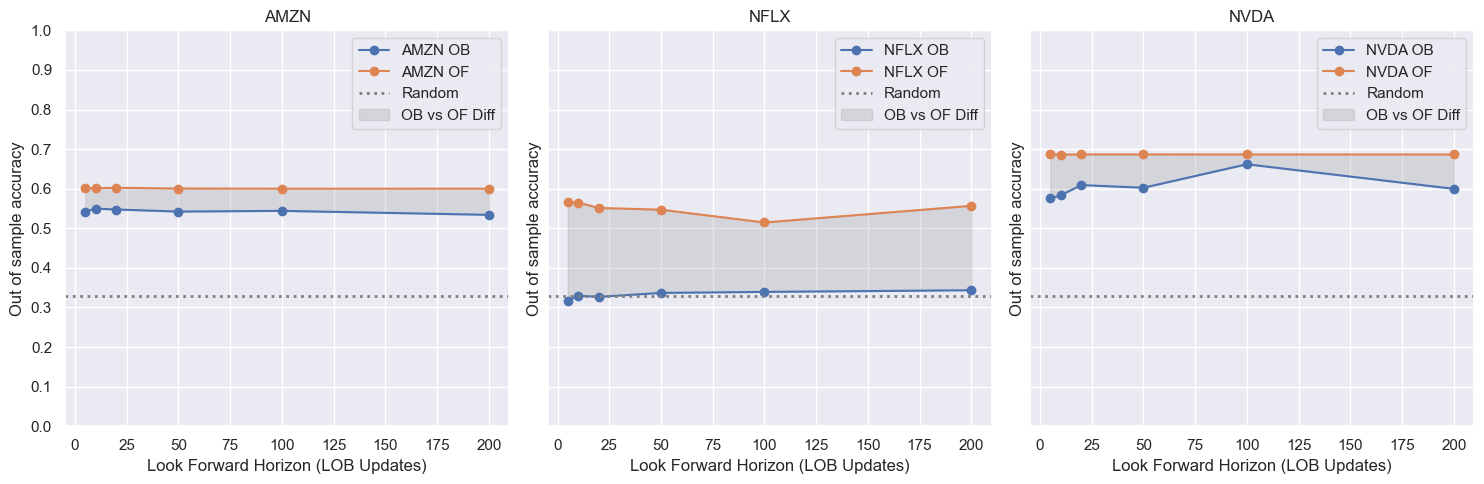

In [197]:
fig, axs = plt.subplots(1, len(inner_tickers), figsize=(15, 5), sharey=True)
if len(inner_tickers) == 1:
    axs = [axs]

for id, ticker in enumerate(sorted(inner_tickers)):
    # For each horizon, pick the first (or best) result for OB and OF
    ob = (
        orderbook[
            (orderbook['meta.ticker'] == ticker) &
            (orderbook['meta.representation'] == 'orderbooks') &
            (orderbook['meta.lookForwardHorizon'] <= 200)
        ]
        .sort_values(['meta.lookForwardHorizon', 'accuracy'], ascending=[True, False])
        .drop_duplicates(subset=['meta.lookForwardHorizon'], keep='first')
    )
    of = (
        orderflow[
            (orderflow['meta.ticker'] == ticker) &
            (orderflow['meta.representation'] == 'orderflows') &
            (orderflow['meta.lookForwardHorizon'] <= 200)
        ]
        .sort_values(['meta.lookForwardHorizon', 'accuracy'], ascending=[True, False])
        .drop_duplicates(subset=['meta.lookForwardHorizon'], keep='first')
    )
    ax = axs[id]
    ax.plot(
        ob['meta.lookForwardHorizon'],
        ob['accuracy'],
        marker='o',
        label=f"{ob['meta.ticker'].iloc[0]} OB"
    )
    ax.plot(
        of['meta.lookForwardHorizon'],
        of['accuracy'],
        marker='o',
        label=f"{of['meta.ticker'].iloc[0]} OF"
    )
    ax.axhline(0.33, color='gray', linestyle=':', linewidth=2, label='Random')
    ax.set_title(ticker)
    ax.set_xlabel('Look Forward Horizon (LOB Updates)')
    ax.set_ylabel('Out of sample accuracy')  # Set y-axis label for all
    ax.set_ylim(0, 1)
    ax.set_yticks([round(y, 1) for y in np.arange(0.0, 1.01, 0.1)])
    # Align OB and OF on lookForwardHorizon for fill_between
    merged = pd.merge(
        ob[['meta.lookForwardHorizon', 'accuracy']],
        of[['meta.lookForwardHorizon', 'accuracy']],
        on='meta.lookForwardHorizon',
        suffixes=('_ob', '_of')
    )
    ax.fill_between(
        merged['meta.lookForwardHorizon'],
        merged['accuracy_ob'],
        merged['accuracy_of'],
        color='gray',
        alpha=0.2,
        label='OB vs OF Diff'
    )
    ax.legend()
plt.tight_layout()
plt.show()
